# Decision Tree Attack and Uniform/Adaptive Extraction
TJ Kim, 26 Oct 2019

We build a decision tree classifier for the data in encoded_adult.csv. The inputs are all the encoded characteristics, while the output is whether or not the income is greater than 50k or not for a person (binary).

We get the class labels only as outputs. Therefore, we do a uniform attack that queries the classifier and uses the output as combinations to make a new trainer. We also truncate the decision tree to rather work with probabilities, and do an adaptive attack.

## Importing Data
First we import CSV data as pandas and divide to test and training set.

In [1]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree

# Import Dataset
filename = "adult_encoded.csv"
df = pd.read_csv(filename, sep='\s*,\s*',engine = 'python')
df = df.loc[:,df.columns != 'Unnamed: 0']

# Separate each dataset into training, testing, and query data
total_rest,total_test = train_test_split(df, random_state=30, test_size=0.2, shuffle=True)
total_train,queries = train_test_split(total_rest,random_state = 30, test_size = 0.4, shuffle = True)

# Separate each sub dataset to input and output
total_train_data = total_train.loc[:,total_train.columns != 'income_over_50k']
total_train_label = total_train.loc[:,total_train.columns =='income_over_50k']
total_test_data = total_train.loc[:,total_test.columns != 'income_over_50k']
total_test_label = total_train.loc[:,total_test.columns =='income_over_50k']
query_data = queries.loc[:,queries.columns !='income_over_50k']
query_label = queries.loc[:,queries.columns =='income_over_50k']

## Build and Run Decision Tree

We use the train data to build a decision tree (of any arbitrary depth at the moment) and use the test data to obtain the accuracy.

In [2]:
# Build and train Decision Tree Classifier
model = tree.DecisionTreeClassifier()
model.fit(total_train_data,total_train_label)

# Prediction and Accuracy
from sklearn.metrics import accuracy_score
y_predict = model.predict(total_test_data)
accuracy_score(total_test_label,y_predict)

0.9787143283709423

The accuracy for the decision tree is significantly better for the logistic regression model. The logistic regression model has approximately 85% accuracy, while the decision tree has 98%. Maybe this is because the dataset we are using has many categorical inputs, which decision trees handle better.

## Utilize Uniform Label Attack to Steal decision tree

Here, we will attack the decision tree by querying the tree and using the output to train our own tree.

In [3]:
# Obtain query labels and then build own decision tree
y_query = model.predict(query_data)
model_stolen = tree.DecisionTreeClassifier()
model_stolen.fit(query_data,y_query)

# Prediction and Accuracy
y_q_predict = model_stolen.predict(total_test_data)
accuracy_score(total_test_label,y_q_predict)

0.8517254617583074

We observe that the accuracy significantly suffers as it falls from 98% to 85% with the uniform attack model. However, that is still very high considering that we attempt a very naive attack.

## Sweep number of queries against performance

Next, we will sweep the number of queries to see how accuracy increases as we query more.

In [4]:
query_num1 = np.arange(5,100,2)
query_num2 = np.arange(100,y_query.size,100)
query_num = np.concatenate([query_num1, query_num2])
accs = np.zeros(query_num.size)
og_acc = np.zeros(query_num.size)
accs_idx = 0

for num in query_num:
    # take subset of query data and obtain labels from real classifier
    samp = query_data.sample(n=num)
    sweep_labels = model.predict(samp)
    # Build stolen classifier with output data
    model_sweep = tree.DecisionTreeClassifier()
    model_sweep.fit(samp,sweep_labels)
    sweep_pred = model_sweep.predict(total_test_data)
    accs[accs_idx] = accuracy_score(total_test_label,sweep_pred)
    
    y_pred = model.predict(total_train_data)
    og_acc[accs_idx] = model.score(total_test_data, total_test_label)
    
    accs_idx += 1

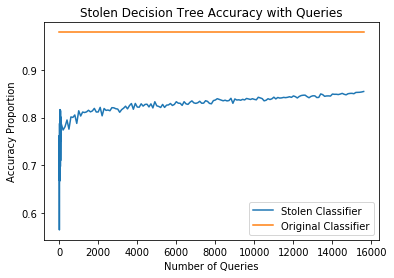

In [5]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Decision Tree Accuracy with Queries")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")

plt.gca().legend(('Stolen Classifier','Original Classifier'))

## Truncating the Decision Tree and Attacking with Different Attacks

Next step, we will truncate the build decision tree to deal with probabilities rather than binaries.

First, we will analyze the existing decision tree.

In [25]:
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import export_graphviz

print("Original model depth: ", model.get_depth())
print("Stolen model depth: ", model_stolen.get_depth())

Original model depth:  48
Stolen model depth:  37


We see that because of the lack of accuracy, we have less depth in our stolen model. This is probably also because we have less data points we trained our model on.

The next step to take would be to truncate both models to 3 layers. 

First we make the truncated model with the original data with a pretty high accuracy score of 84%.

In [41]:
# Build and train Decision Tree Classifier
model_t = tree.DecisionTreeClassifier(max_depth = 3)
model_t.fit(total_train_data,total_train_label)

# Prediction and Accuracy
y_predict = model_t.predict(total_test_data)
y_probs = model_t.predict_proba(total_test_data)
acc = accuracy_score(total_test_label,y_predict)

print("Accuracy Score: ", acc)

Accuracy Score:  0.8451136799897624


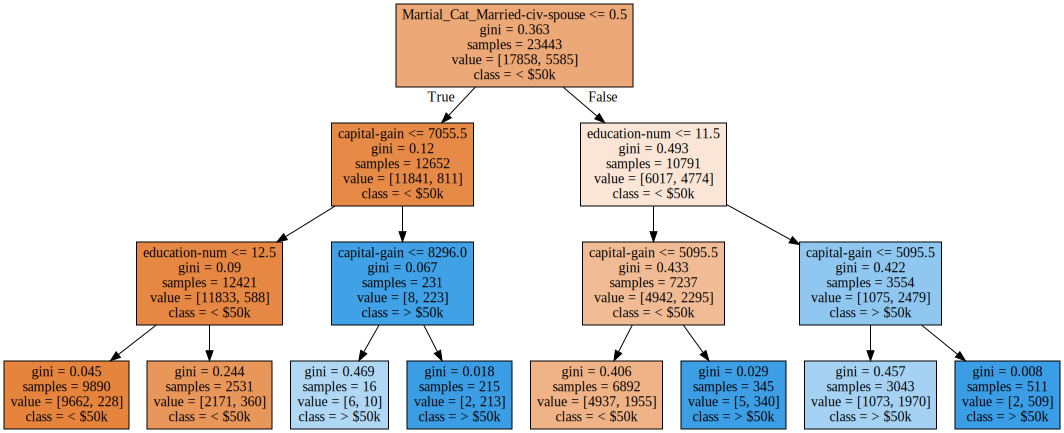

In [42]:
graph = Source(tree.export_graphviz(model_t, out_file=None
   , feature_names= df.columns[0:39], class_names=['< $50k','> $50k'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

#### Uniform Attack

We perform a uniform attack and observe the accuracy.

In [167]:
query_num = np.arange(10,1000,10)
accs = np.zeros(query_num.size)
og_acc = np.zeros(query_num.size)
accs_idx = 0

for num in query_num:
    # take subset of query data and obtain labels from real classifier
    samp = query_data.sample(n=num)
    sweep_labels = model_t.predict(samp)
    # Build stolen classifier with output data
    model_sweep_t = tree.DecisionTreeClassifier(max_depth=3)
    model_sweep_t.fit(samp,sweep_labels)
    sweep_pred = model_sweep_t.predict(total_test_data)
    accs[accs_idx] = accuracy_score(total_test_label,sweep_pred)
    
    y_pred = model_t.predict(total_train_data)
    og_acc[accs_idx] = model_t.score(total_test_data, total_test_label)
    
    accs_idx += 1

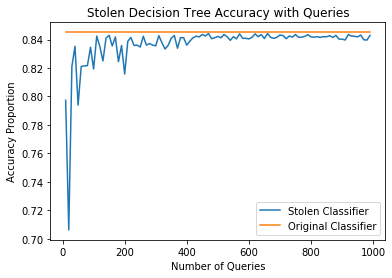

In [168]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Decision Tree Accuracy with Queries")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")

plt.gca().legend(('Stolen Classifier','Original Classifier'))

#### Adaptive training attack
Here we iteratively build a model by sampling the most unsure values as we increase the number of queries.

In [170]:
# Sim params
num_iters = 100
accs2 = np.zeros(num_iters-1)
accs_idx = 0
query_num2 = range(10,1000,10)

# First we sample 10 points at random to build an initial model
num = 10
collected_queries = query_data.sample(n=num).to_numpy()
collected_labels = model_t.predict(collected_queries)
# Build stolen classifier with output data
model_sweep_t = tree.DecisionTreeClassifier(max_depth=10)
model_sweep_t.fit(collected_queries,collected_labels)

for itr in range(0,len(query_num2)):
    num = 10
    # take subset of query data and obtain labels from real classifier
    samp = query_data.sample(n=num * 5)
    
    # We find labels with lowest probability for our current model
    curr_preds = model_sweep_t.predict_proba(samp)
    confs = abs(curr_preds[:,1] - 0.5)
    idxs = confs.argsort()[:num]
    
    # Get new query data
    np_samp_min = samp.to_numpy()[idxs,:]
    
    # Append to total data and Get new labels
    collected_queries = np.append(collected_queries,np_samp_min,axis = 0)
    sweep_labels = model_t.predict(np_samp_min)
    collected_labels = np.append(collected_labels,sweep_labels)
    
    # Build stolen classifier with output data
    model_sweep_t = tree.DecisionTreeClassifier(max_depth=3)
    model_sweep_t.fit(collected_queries,collected_labels)
    sweep_pred = model_sweep_t.predict(total_test_data)
    accs2[itr] = accuracy_score(total_test_label,sweep_pred)

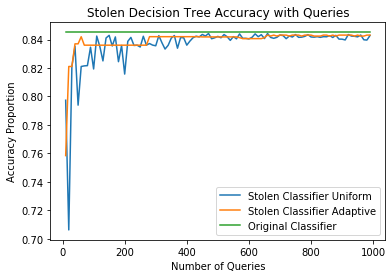

In [171]:
# Plot the accuracy
plt.plot(query_num,accs)
plt.plot(query_num2,accs2)
plt.plot(query_num,og_acc, label = "Original Classifier")
plt.title("Stolen Decision Tree Accuracy with Queries")
plt.xlabel("Number of Queries")
plt.ylabel("Accuracy Proportion")

plt.gca().legend(('Stolen Classifier Uniform','Stolen Classifier Adaptive','Original Classifier'))

We observe for the decision tree case, the uniform attack does perform similarily to the adaptive attack during the beginning. However, the two performances soon converge around 200 queries. The adaptive attack may not be effective for decision trees as we are not infact querying near the "decision boundary" of parametric approaches, but rather querying data with high uncertainty (potentially in the original classifier as well). It is important to note that the adaptive method is less noisy.

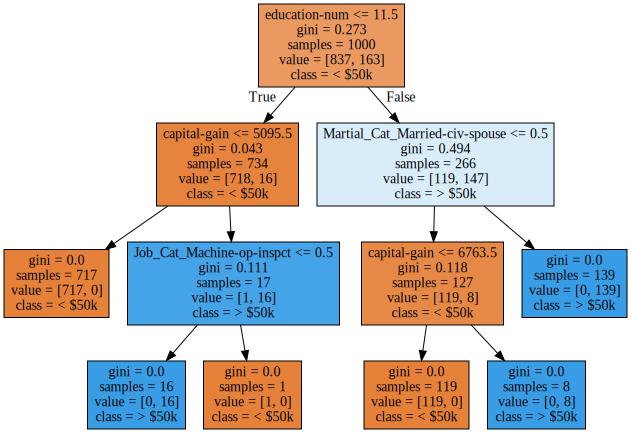

In [172]:
graph = Source(tree.export_graphviz(model_sweep_t, out_file=None
   , feature_names= df.columns[0:39], class_names=['< $50k','> $50k'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))